In [1]:
import pandas as pd
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx
import rasterio
from rasterio.crs import CRS
from rasterio.transform import from_bounds
from shapely import force_2d
from shapely.geometry import box, Point, Polygon, MultiPolygon
from scipy.spatial import cKDTree
from sklearn.gaussian_process import GaussianProcessRegressor
from pykrige.rk import Krige
from pykrige.ok import OrdinaryKriging
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from flood_density.plots import plot_gdf, city_bounds_and_density_plot
from flood_density.preprocess import convert_kml_to_gdf, export_to_geojson, get_bounds_xy_min_max, extract_bounds_polygon, polygon_to_geodataframe, extract_city_data, coordinates_to_box,points_geocoordinates,convert_points_in_gdf, extract_city_bounds_from_df_to_gdf , gdf_to_geojson, clip_density_to_urban_area

from typing import List, Tuple, Callable

CRS_4326 = 4326


# Etapa 1 : Obtener datos .kml de la ciudad de La Plata.

In [2]:
gdf_from_kml = convert_kml_to_gdf('laplata_cascourbano.kml')

/home/andy/.local/lib/python3.10/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'laplata_cascourbano.kml': 'La Plata' (default), 'La Plata (#2)', 'La Plata (#3)'. Specify layer parameter to avoid this warning.
  result = read_func(


In [3]:
gdf_peligrosidad = export_to_geojson(gdf_from_kml, 'laplata_cascourbano.geojson')

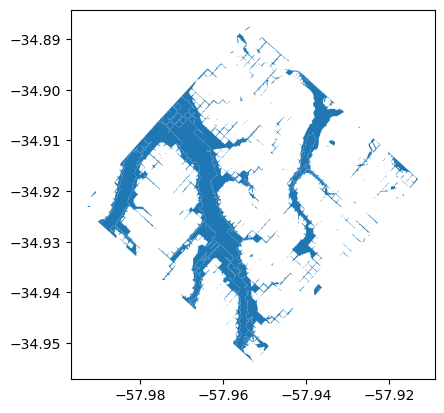

In [4]:
plot_peligrosidad = plot_gdf(gdf_peligrosidad)

# Etapa 2: Obtener las coordenadas de los puntos de la ciudad, formamos un polígono y luego, transformamos a un gdf.


In [5]:
#¿Cómo obtengo bounds_dict? son coordenadas de la ciudad de La Plata Desde el archivo geojson

In [6]:
#Extraemos las coordenadas geográficas de la ciudad 
city_bounds_coordinates= get_bounds_xy_min_max(gdf_peligrosidad)
city_bounds_coordinates

{'x_min': -57.992667,
 'y_min': -34.953843,
 'x_max': -57.91312,
 'y_max': -34.887489}

In [7]:
# Convertimos las coordenadas de la ciudad a un box
boxx = coordinates_to_box(city_bounds_coordinates)

In [8]:
#Usar el dataframe del polígono que forma las coordenadas de la LP
gdf_la_plata_from_polygon = gpd.GeoDataFrame({'geometry': [boxx]}, crs='EPSG:4326')

In [9]:
# Convertir a EPSG 32721 (UTM zona 21S)
gdf_la_plata_from_polygon = gdf_la_plata_from_polygon.to_crs(epsg=32721)

# Etapa 3 : Obtener y transformar datos de densidad poblacional de la ciudad de La Plata.

Primero extraemos las filas que pertenecen a la ciudad de La Plata(sigue siendo un .csv), luego convertimos ese dataframe en un geodataframe.

In [10]:
#Levantamos el dataset completo
df_arg = pd.read_csv("arg_pd_2020_1km_ASCII_XYZ.csv") 

In [11]:
# Extraemos las filas referidas a la ciudad de La Plata
df_lp_coordinates = extract_city_data(df_arg,'la_plata',city_bounds_coordinates)
df_lp_coordinates

,X,Y,Z
2005769,-57.988750,-34.887916,4390.450195
2005770,-57.980416,-34.887916,4219.690918
2005771,-57.972083,-34.887916,3577.566895
2005772,-57.963750,-34.887916,4450.521973
2005773,-57.955416,-34.887916,3841.554199
...,...,...,...
2016355,-57.947083,-34.946250,4543.715820
2016356,-57.938750,-34.946250,4086.931885
2016357,-57.930416,-34.946250,3947.445801
2016358,-57.922083,-34.946250,3537.828613


In [12]:
#Leemos los datos específicos de la ciudad de La Plata
df_lp_coordinates = pd.read_csv('la_plata_population_2020.csv')
df_lp_coordinates


,X,Y,Z
0,-57.988750,-34.887916,4390.450195
1,-57.980416,-34.887916,4219.690918
2,-57.972083,-34.887916,3577.566895
3,-57.963750,-34.887916,4450.521973
4,-57.955416,-34.887916,3841.554199
...,...,...,...
75,-57.947083,-34.946250,4543.715820
76,-57.938750,-34.946250,4086.931885
77,-57.930416,-34.946250,3947.445801
78,-57.922083,-34.946250,3537.828613


In [13]:
#Convertir dataframe de los puntos pertenecientes a la ciudad de La Plata en un geodataframe
gdf_lp_coordinates = extract_city_bounds_from_df_to_gdf(df_lp_coordinates, 'Y','X')

In [14]:
# Extraemos las coordenadas de los puntos dentro de la ciudad de La Plata
casco_urbano = clip_density_to_urban_area(gdf_lp_coordinates,gdf_peligrosidad)

In [15]:
# Reproyectar a EPSG 32721 (UTM zona 21S)
casco_urbano_utm = casco_urbano.to_crs(epsg=32721)
casco_urbano_utm

,X,Y,Z,geometry,Name,Description
22,-57.972083,-34.904583,5416.428223,POINT (411191.477 6137107.129),La Plata,descripción: <br>name: La Plata <br>descriptio...
31,-57.980416,-34.912916,5103.672852,POINT (410439.177 6136175.537),La Plata,descripción: <br>name: La Plata <br>descriptio...
33,-57.963750,-34.912916,5795.110352,POINT (411961.724 6136190.323),La Plata,descripción: <br>name: La Plata <br>descriptio...
36,-57.938750,-34.912916,4231.409668,POINT (414245.539 6136212.026),La Plata,descripción: <br>name: La Plata <br>descriptio...
43,-57.963750,-34.921250,5794.330078,POINT (411970.623 6135266.155),La Plata,descripción: <br>name: La Plata <br>descriptio...
53,-57.963750,-34.929583,5190.817871,POINT (411979.523 6134341.986),La Plata,descripción: <br>name: La Plata <br>descriptio...
54,-57.955416,-34.929583,5635.426758,POINT (412740.641 6134349.285),La Plata,descripción: <br>name: La Plata <br>descriptio...
56,-57.938750,-34.929583,5082.848633,POINT (414262.876 6134363.694),La Plata,descripción: <br>name: La Plata <br>descriptio...
64,-57.955416,-34.937916,5090.878418,POINT (412749.467 6133425.116),La Plata,descripción: <br>name: La Plata <br>descriptio...
74,-57.955416,-34.946250,4224.697266,POINT (412758.294 6132500.945),La Plata,descripción: <br>name: La Plata <br>descriptio...


In [16]:
# Calcular centroides en el CRS proyectado
centroides = casco_urbano_utm.geometry.centroid

In [17]:
# Convertir centroides a un array de coordenadas
coords_centroides = np.array([[pt.x, pt.y] for pt in centroides])

In [18]:
# Extraer densidades de casco_urbano_utm
values_density_lp = casco_urbano_utm['Z'].values

In [19]:
#Extraer los límites del polígono de la ciudad de La Plata
bounds_lp = gdf_la_plata_from_polygon.total_bounds  # [minx, miny, maxx, maxy]
bounds_lp

array([ 409292.09738085, 6131625.70628701,  416628.30365384,
       6139053.5533489 ])

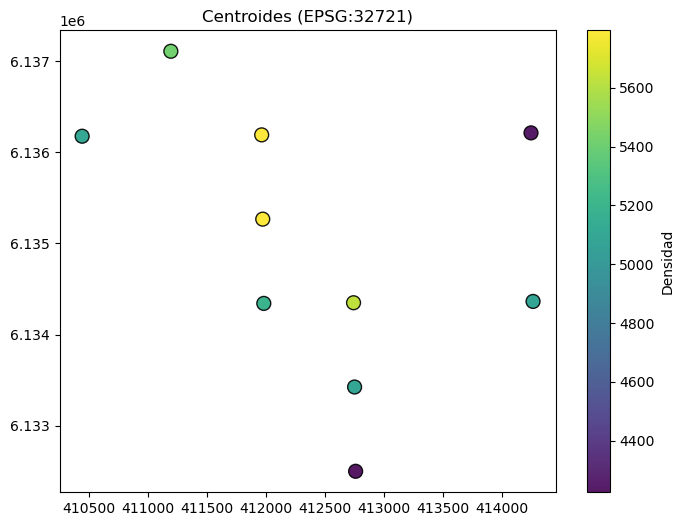

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(coords_centroides[:, 0], coords_centroides[:, 1],
                c=values_density_lp, s=100,
                cmap='viridis', alpha=0.9,
                edgecolor='black', linewidth=1,
                marker='o')

plt.colorbar(sc, ax=ax, label='Densidad')
ax.set_title("Centroides (EPSG:32721)")
plt.show()

# Etapa 4 : Merge polígono y zona de densidad de la ciudad de La Plata en un plot para corroborar consistencia geográfica.

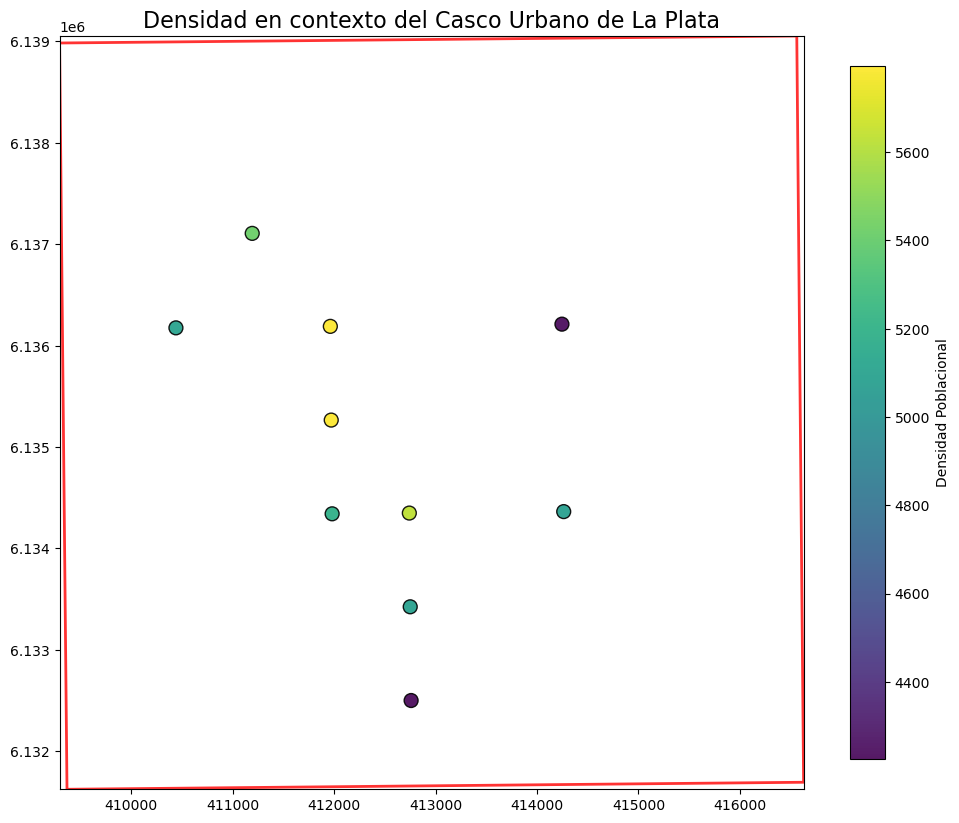

In [21]:
city_bounds_and_density_plot(gdf_la_plata_from_polygon, coords_centroides, values_density_lp, bounds_lp)

# Etapa 5 :  Visualización de la densidad poblacional de La Plata usando kriging.

In [22]:
casco_urbano_utm

,X,Y,Z,geometry,Name,Description
22,-57.972083,-34.904583,5416.428223,POINT (411191.477 6137107.129),La Plata,descripción: <br>name: La Plata <br>descriptio...
31,-57.980416,-34.912916,5103.672852,POINT (410439.177 6136175.537),La Plata,descripción: <br>name: La Plata <br>descriptio...
33,-57.963750,-34.912916,5795.110352,POINT (411961.724 6136190.323),La Plata,descripción: <br>name: La Plata <br>descriptio...
36,-57.938750,-34.912916,4231.409668,POINT (414245.539 6136212.026),La Plata,descripción: <br>name: La Plata <br>descriptio...
43,-57.963750,-34.921250,5794.330078,POINT (411970.623 6135266.155),La Plata,descripción: <br>name: La Plata <br>descriptio...
53,-57.963750,-34.929583,5190.817871,POINT (411979.523 6134341.986),La Plata,descripción: <br>name: La Plata <br>descriptio...
54,-57.955416,-34.929583,5635.426758,POINT (412740.641 6134349.285),La Plata,descripción: <br>name: La Plata <br>descriptio...
56,-57.938750,-34.929583,5082.848633,POINT (414262.876 6134363.694),La Plata,descripción: <br>name: La Plata <br>descriptio...
64,-57.955416,-34.937916,5090.878418,POINT (412749.467 6133425.116),La Plata,descripción: <br>name: La Plata <br>descriptio...
74,-57.955416,-34.946250,4224.697266,POINT (412758.294 6132500.945),La Plata,descripción: <br>name: La Plata <br>descriptio...


In [23]:
values_density_lp = casco_urbano_utm['Z'].values

In [24]:
# 1. Preparar los datos (se queda)

def prepare_data(gdf: gpd.GeoDataFrame, value_column: str):
    coords = np.array([[point.x, point.y] for point in gdf.geometry.centroid])
    values = gdf[value_column].values
    print(f"Datos de entrada: {len(coords)}")
    print(f"Rango de valores: {values.min():.2f} - {values.max():.2f}")
    return coords, values

In [25]:
prepare_data(casco_urbano_utm, 'Z')

Datos de entrada: 10
Rango de valores: 4224.70 - 5795.11


(array([[ 411191.47705537, 6137107.12919731],
        [ 410439.17718122, 6136175.53731404],
        [ 411961.72382994, 6136190.32296704],
        [ 414245.53895849, 6136212.02599051],
        [ 411970.62252151, 6135266.15516394],
        [ 411979.52307898, 6134341.98612686],
        [ 412740.64147876, 6134349.28542649],
        [ 414262.87636074, 6134363.69380399],
        [ 412749.4669027 , 6133425.11593676],
        [ 412758.29417604, 6132500.94521217]]),
 array([5416.42822266, 5103.67285156, 5795.11035156, 4231.40966797,
        5794.33007812, 5190.81787109, 5635.42675781, 5082.84863281,
        5090.87841797, 4224.69726562]))

In [ ]:
# 2. Ajustar el modelo de Kriging
#def fit_kriging(coords: np.ndarray, values: np.ndarray) -> OrdinaryKriging:
#    OK = OrdinaryKriging(
#        coords[:,0], coords[:,1], values,
#        variogram_model='gaussian',
#        verbose=False,
#        enable_plotting=False
#    )
#    return OK

In [ ]:
#model_fit_kriging = fit_kriging(coords_centroides, values_density_lp)

In [ ]:
# 3. Crear malla para interpolar
#def create_grid(bounds: Tuple[float, float, float, float], step: int = 100) -> Tuple[np.ndarray, np.ndarray]:
#    x = np.linspace(bounds[0], bounds[1], step)
#    y = np.linspace(bounds[2], bounds[3], step)
#    grid_x, grid_y = np.meshgrid(x, y)
#    return grid_x, grid_y

In [ ]:
#grid = create_grid(bounds_lp, step=100)

(array([[ 409292.09738085,  467093.44696576,  524894.79655067, ...,
         6016023.00711719, 6073824.3567021 , 6131625.70628701],
        [ 409292.09738085,  467093.44696576,  524894.79655067, ...,
         6016023.00711719, 6073824.3567021 , 6131625.70628701],
        [ 409292.09738085,  467093.44696576,  524894.79655067, ...,
         6016023.00711719, 6073824.3567021 , 6131625.70628701],
        ...,
        [ 409292.09738085,  467093.44696576,  524894.79655067, ...,
         6016023.00711719, 6073824.3567021 , 6131625.70628701],
        [ 409292.09738085,  467093.44696576,  524894.79655067, ...,
         6016023.00711719, 6073824.3567021 , 6131625.70628701],
        [ 409292.09738085,  467093.44696576,  524894.79655067, ...,
         6016023.00711719, 6073824.3567021 , 6131625.70628701]]),
 array([[ 416628.30365384,  416628.30365384,  416628.30365384, ...,
          416628.30365384,  416628.30365384,  416628.30365384],
        [ 474430.57890329,  474430.57890329,  474430.57890329

In [ ]:
##def interpolate_grid(bounds: Tuple[float, float, float, float], step: int = 100) -> Tuple[np.ndarray, np.ndarray]:
#    """
#    Genera las coordenadas de la malla donde luego se predicen valores con OrdinaryKriging.
#    """
#    x = np.linspace(bounds[0], bounds[1], step)
#    y = np.linspace(bounds[2], bounds[3], step)
#    grid_x, grid_y = np.meshgrid(x, y)
#    return grid_x, grid_y


In [ ]:
#grid_x, grid_y = interpolate_grid(bounds_lp, step=100)


In [ ]:
#def predict_grid(model: OrdinaryKriging, grid_x: np.ndarray, grid_y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
#    """
#    Predice valores e incertidumbres en un grid usando OrdinaryKriging.
#    """
#    z, ss = model.execute('grid', grid_x[0], grid_y[:,0])
#    return z, ss


In [ ]:
#predict_grid(model_fit_kriging, grid_x, grid_y)

(masked_array(
   data=[[4865.821494057534, 4865.821494057534, 4865.821494057534, ...,
          4865.821494057534, 4865.821494057534, 4865.821494057534],
         [4865.821494057534, 4865.821494057534, 4865.821494057534, ...,
          4865.821494057534, 4865.821494057534, 4865.821494057534],
         [4865.821494057534, 4865.821494057534, 4865.821494057534, ...,
          4865.821494057534, 4865.821494057534, 4865.821494057534],
         ...,
         [4865.821494057534, 4865.821494057534, 4865.821494057534, ...,
          4865.821494057534, 4865.821494057534, 4865.821494057534],
         [4865.821494057534, 4865.821494057534, 4865.821494057534, ...,
          4865.821494057534, 4865.821494057534, 4865.821494057534],
         [4878.299616389546, 4865.821494057534, 4865.821494057534, ...,
          4865.821494057534, 4865.821494057534, 4865.821494057534]],
   mask=[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [Fals

In [ ]:
#def plot_kriging_results_with_basemap(gdf: gpd.GeoDataFrame, 
#                                      coords: np.ndarray, 
#                                      bounds: Tuple[float, float, float, float], 
#                                      grid_x: np.ndarray, 
#                                      grid_y: np.ndarray, 
#                                      model: OrdinaryKriging, 
#                                      predict_fn: Callable[[OrdinaryKriging, np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray]]) -> plt.Figure:
#
#    fig, ax = plt.subplots(figsize=(10, 10))
#
#    # Obtener la superficie interpolada desde la función predict_fn
#    grid_z, ss = predict_fn(model, grid_x, grid_y)
#    
#    # Plotear superficie Kriging interpolada
#    contour = ax.contourf(grid_x, grid_y, grid_z, levels=30, cmap='viridis', alpha=0.5)
#    
#
#    # Plotear los polígonos originales
#    casco_urbano_utm.plot(column='Z', 
#               cmap='viridis',
#               alpha=0.5,
#               edgecolor='black',
#               linewidth=1.0,
#               ax=ax)
#
#    # Plotear los polígonos originales con bordes
#    casco_urbano_utm.plot(column='Z', 
#               cmap='viridis',
#               alpha=0.5,
#               edgecolor='black',
#               linewidth=1.0,
#               ax=ax)
#
#    # Plotear los puntos centroides
#    scatter = ax.scatter(coords[:, 0], coords[:, 1],
#                    c=gdf['Z'],
#                    cmap='viridis',
#                    s=30,
#                    edgecolors='black',
#                    linewidths=1,
#                    zorder=5)
#
#    # Ajustar límites del gráfico según los límites de La Plata
#    ax.set_xlim(bounds[0], bounds[2])
#    ax.set_ylim(bounds[1], bounds[3])
#
#    #Mapa base más sutil
#    ctx.add_basemap(ax, crs=casco_urbano_utm.crs.to_string(),
#                   source=ctx.providers.CartoDB.Positron,
#                   alpha = 0.9)
#
#    # Agregar colorbar para el scatter
#    plt.colorbar(scatter, ax=ax, label='Densidad poblacional',shrink=0.7, aspect=25)
#
#    # Agregar título y etiquetas
#    ax.set_title('Interpolación Kriging - Densidad Poblacional La Plata')
#    ax.set_xlabel('X (UTM)')
#    ax.set_ylabel('Y (UTM)')
#
#    plt.tight_layout()
#    plt.show()
#

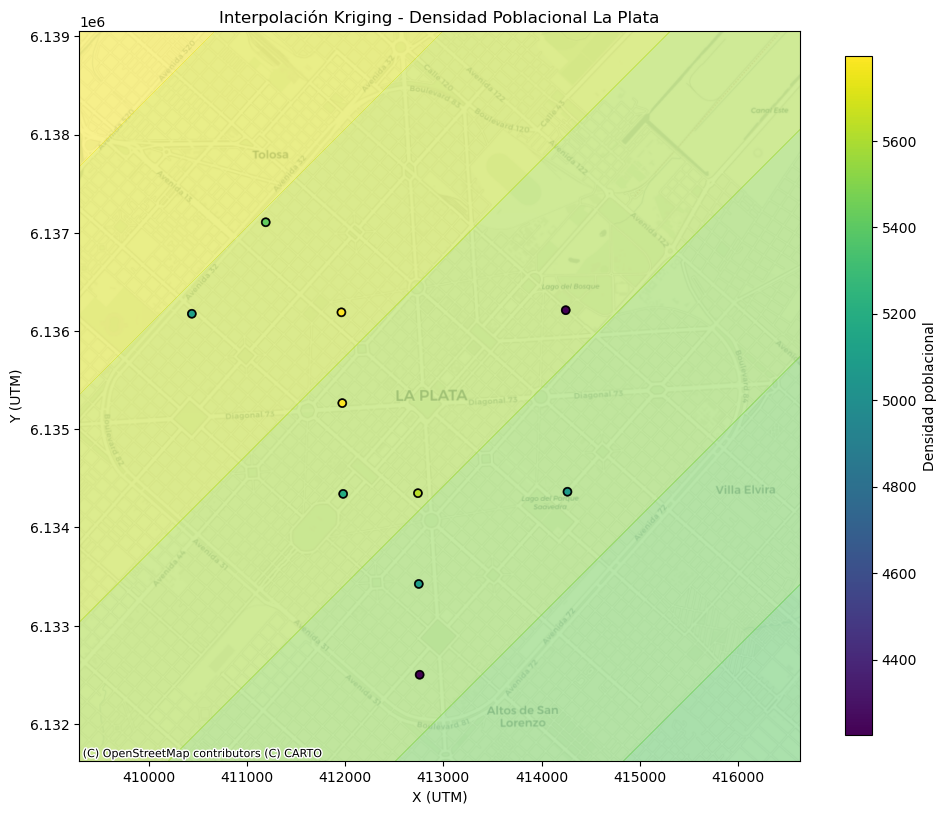

In [ ]:
#plot_kriging_results_with_basemap(casco_urbano_utm, coords_centroides, bounds_lp, grid_x, grid_y, model_fit_kriging, predict_grid)

In [ ]:
# 5. Pipeline principal
#def run_kriging_pipeline(geodf, value_column, bounds, step=100):
#    coords, values = prepare_data(geodf, value_column)
#    model = fit_kriging(coords, values)
#    grid_xx, grid_yy, z = interpolate_grid(model, bounds, step)
#    plot_kriging_results(grid_xx, grid_yy, z, coords, values, bounds)

----------------------------------------------------------------------------------------------------------------------------------------------------

In [37]:
# 2. Ajustar el modelo de Kriging
def fit_kriging(kernel: Any, coords: np.ndarray, values: np.ndarray) -> OrdinaryKriging:
    OK = OrdinaryKriging(
        coords[:,0], coords[:,1], values,
        variogram_model='gaussian',
        verbose=False,
        enable_plotting=False
    )
    return OK

NameError: name 'Any' is not defined

In [38]:
def create_kriging_kernel(constant_value=1.0, length_scale=1000.0, noise_level=0.1,
                          length_scale_bounds=(1e-5, 1e5), noise_level_bounds=(1e-10, 1e3)):
    """
    Crea un kernel para un modelo de Kriging (Gaussian Process).

    Parámetros:
    - constant_value: valor inicial del ConstantKernel
    - length_scale: valor inicial del RBF kernel
    - noise_level: valor inicial del WhiteKernel
    - length_scale_bounds: límites para optimización del RBF
    - noise_level_bounds: límites para optimización del WhiteKernel

    Retorna:
    - kernel: objeto kernel listo para usar en GaussianProcessRegressor
    """
    kernel = ConstantKernel(constant_value) * RBF(length_scale=length_scale,
                                                  length_scale_bounds=length_scale_bounds) + \
             WhiteKernel(noise_level=noise_level, noise_level_bounds=noise_level_bounds)
    return kernel


In [39]:
kernel = create_kriging_kernel()
print(kernel)


1**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=0.1)


In [ ]:
#Definir kernel para el modelo de kriging
kernel = (ConstantKernel(1.0) * RBF(length_scale=1000.0) + 
          WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e3)))

# Crear modelo de kriging
gpr = GaussianProcessRegressor(kernel=kernel,
                                n_restarts_optimizer=10,
                                alpha=1e-04,
                                normalize_y=True)

In [ ]:
# Visualización de la densidad poblacional de La Plata usando kriging

# Extraer coordenadas y valores desde el GeoDataFrame
coords =np.array([[point.x, point.y] for point in casco_utm.geometry.centroid])
values = casco_urbano['densidad_poblacional_lp'].values

print(f"Puntos de datos: {len(coords)}")
print(f"Rango de valores: {values.min():.2f} - {values.max():.2f}")

#Definir kernel para el modelo de kriging
kernel = (ConstantKernel(1.0) * RBF(length_scale=1000.0) + 
          WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e3)))

# Crear modelo de kriging
gpr = GaussianProcessRegressor(kernel=kernel,
                                n_restarts_optimizer=10,
                                alpha=1e-04,
                                normalize_y=True)

# Crear grid de puntos para interpolación
bounds_casco_lp = casco_utm.total_bounds
grid_x, grid_y = np.mgrid[bounds_casco_lp[0]:bounds_casco_lp[2]:100j, bounds_casco_lp[1]:bounds_casco_lp[3]:100j]
grid_coords = np.column_stack([grid_x.ravel(), grid_y.ravel()])



# Entrenar el modelo
gpr.fit(coords, values)

#Predecir en el grid
grid_2_kriging, pred_std = gpr.predict(grid_coords, return_std=True)
grid_z = grid_2_kriging.reshape(grid_x.shape)
grid_uncertainty = pred_std.reshape(grid_x.shape)

# Visualización de la superficie Kriging interpolada
fig, ax = plt.subplots(figsize=(8, 10))

# Plotear superficie Kriging interpolada
contour = ax.contourf(grid_x, grid_y, grid_z, levels=30, cmap='viridis', alpha=0.7)

# Plotear los polígonos originales con bordes
casco_utm.plot(column='densidad_poblacional_lp', 
               cmap='viridis',
               alpha=0.5,
               edgecolor='black',
               linewidth=1.0,
               ax=ax)

# Plotear los puntos centroides
scatter = ax.scatter(coords[:, 0], coords[:, 1],
                    c=values,
                    cmap='viridis',
                    s=30,
                    edgecolors='black',
                    linewidths=1,
                    zorder=5)

#Mapa base más sutil
ctx.add_basemap(ax, crs=casco_utm.crs.to_string(),
               source=ctx.providers.CartoDB.Positron,
               alpha = 0.9)

# Agregar colorbar para el scatter
plt.colorbar(scatter, ax=ax, label='Densidad poblacional',shrink=0.7, aspect=25)

# Agregar título y etiquetas
ax.set_title('Interpolación Kriging - Densidad Poblacional La Plata')
ax.set_xlabel('X (UTM)')
ax.set_ylabel('Y (UTM)')

plt.tight_layout()
plt.show()


In [ ]:
def export_to_geotiff(grid_data: np.ndarray, gdf: gpd.GeoDataFrame,  crs_epsg: int = 32721):

     # Crear un GeoDataFrame con los límites del área de La Plata en EPSG:4326
    boxx = coordinates_to_box(city_bounds_coordinates) 
    gdf_la_plata_from_polygon = gpd.GeoDataFrame({'geometry': [boxx]}, crs='EPSG:4326')
    
    # Transformar al CRS del plot
    gdf_la_plata_from_polygon = gdf_la_plata_from_polygon.to_crs(epsg=32721)

    # Obtener límites en coordenadas proyectadas
    bounds_proj = gdf_la_plata_from_polygon.total_bounds  # [xmin, ymin, xmax, ymax]
    height, width = grid_data.shape

    # Calcula la transformación georreferenciada
    transform = from_bounds(bounds_proj[0], bounds_proj[1], bounds_proj[2], bounds_proj[3], width, height)

    with rasterio.open(
        filename,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=grid_data.dtype,
        crs=CRS.from_epsg(crs_epsg),
        transform=transform,
        compress='lzw'
    ) as dst:
        dst.write(grid_data, 1)
        dst.set_band_description(1, 'Densidad Poblacional Kriging')



In [ ]:
# Exportar superficie interpolada
export_to_geotiff(grid_z, gdf_la_plata_from_polygon, 32721)

# Etapa 5 : superposición de mapas de densidad y peligrosidad de inundación de la ciudad de La Plata (QGIS).